In [159]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

In [160]:
import scraper
import networkx as nx

category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
    #"Category:Wikipedia_level-4_vital_articles",
    #"Category:Wikipedia_level-5_vital_articles"
]

page_graph, infos  = await scraper.scrape_wiki(category_titles)
nx.write_graphml(page_graph, "wikigraph.graphml")

Fetching 1001 plaintext wiki pages: 100%|██████████| 1001/1001 [00:06<00:00, 147.44it/s]


In [ ]:
import os
import scraper
import re
import numpy as np
import networkx as nx
from tqdm.asyncio import tqdm

def parse_page(raw_content):
    # Normalize whitespace
    content = re.sub(r'[\n\t\ ]+', ' ', raw_content)

    # Retreive links to all pages
    all_links = np.unique(re.findall('\[([^/\]\[\|]+)[\]\|]', content))
    # Retreive links to User: pages
    user_links = np.unique(re.findall('\[(User:[^/\]\[\|]+)[\]\|]', content))
    # Retreive links to Talk: pages
    talk_links = np.unique(re.findall('\[((talk:|Talk:|User talk:|Wikipedia talk:)[^/\]\[\|]+)[\]\|]', content))
    article_links = [link for link in all_links if link not in user_links and link not in talk_links]
    return {"article": article_links, "user": user_links, "talk": talk_links}

def get_titles(filenames):
    return [fname[:-4] if fname[-4:] == ".txt" else fname for fname in filenames]

def parse_class(titles, dirpath):
    data = {}
    for title in titles:
        filepath = f"{dirpath}/{title}.txt"
        if os.path.isfile(filepath):
            with open(filepath, "r") as fh:
                content = fh.read()
                data[title] = parse_page(content)
        else:
            pass
    return data

def build_network_local():
    path = "./page_contents"
    talk_titles = get_titles(os.listdir(f"{path}/talks"))
    article_titles = get_titles(os.listdir(f"{path}/articles"))
    
    # Graph
    page_graph = nx.DiGraph()

    for talk_page_title in talk_titles:
        page_graph.add_node(talk_page_title, page_class="talk")
    for wiki_page_title in article_titles:
        page_graph.add_node(wiki_page_title, page_class="article")
        page_graph.add_edge(f"Talk:{wiki_page_title}", wiki_page_title)

        
    talk_data = parse_class(talk_titles, f"{path}/talks")
    articles_data = parse_class(article_titles, f"{path}/articles")

    link_types = ["article", "user", "talk"]

    count = 0
    disregarded = []
    # Add User: links to graph
    for title in tqdm(talk_data.keys(), desc="Adding talk page links"):
        page_data = talk_data[title]
        if page_data is not None and title in page_graph:
            for key in link_types:
                for link in page_data[key]:
                    if link not in page_graph:
                        page_graph.add_node(link, page_class=key)
                    page_graph.add_edge(link, title)
                    count += 1
        else:
            disregarded.append(title) # Talk:HIV for some reason
    # Add User: links to graph
    for title in tqdm(articles_data.keys(), desc="Adding article page links"):
        page_data = articles_data[title]
        if page_data is not None and title in page_graph:
            for key in link_types:
                for link in page_data[key]:
                    if link not in page_graph:
                        page_graph.add_node(link, page_class=key)
                    page_graph.add_edge(link, title)
                    count += 1
        else:
            disregarded.append(title)

    print("Total edges: " + str(count))
    print(f"Disregarded nodes: {len(disregarded)}")
    return page_graph

# graph = build_network_local()

In [1]:
import networkx as nx
graph = nx.read_graphml("wikigraph.graphml")
# remove bots
bot_names = ["User:Community Tech bot", "User:PrimeBOT", "User:InternetArchiveBot", "User:AnomieBOT", "User:RMCD bot", "User:Cyberbot II", "User:CommonsNotificationBot",
"User:LinkBot", "User:FairuseBot", "User:BetacommandBot", "User:Legobot", "User:DumZiBoT"]
graph.remove_nodes_from(bot_names)


## Basic statistics

In [2]:
import numpy as np
import pandas as pd
import networkx as nx

def largest_weakly_connected_c(graph):
     # extract largest weakly connected component
    connected_subgraphs = [graph.subgraph(c).copy() for c in nx.weakly_connected_components(graph)]
    max_conn_subgraph_index = np.argmax([len(graph) for graph in connected_subgraphs])
    return connected_subgraphs[max_conn_subgraph_index]

def largest_connected_c(graph):
     # extract largest connected component
    connected_subgraphs = [graph.subgraph(c).copy() for c in nx.connected_components(graph)]
    max_conn_subgraph_index = np.argmax([len(graph) for graph in connected_subgraphs])
    return connected_subgraphs[max_conn_subgraph_index]

def top_n_by_degree(degree_dict, n):
    stat_view = pd.DataFrame(degree_dict, columns=["Node", "Degree"]).set_index("Node")
    return stat_view.sort_values(["Degree"], ascending=False).head(n)

def basic_stats_undirected(graph, top_n):
    G_biggest_comp = largest_connected_c(graph)
    degree_stats = top_n_by_degree(G_biggest_comp.degree, top_n)
    return G_biggest_comp, degree_stats
    
def basic_stats_directed(graph, top_n):
    G_biggest_comp = largest_weakly_connected_c(graph)
    # Create degree statistics
    degree_stats = top_n_by_degree(G_biggest_comp.degree, top_n)
    in_degree_stats = top_n_by_degree(G_biggest_comp.in_degree, top_n)
    out_degree_stats = top_n_by_degree(G_biggest_comp.out_degree, top_n)

    stats = {"degree": degree_stats, "in_degree": in_degree_stats, "out_degree": out_degree_stats}
    return G_biggest_comp, stats

In [3]:
def create_grouping(graph, data_key):
    nodes_with_grouping = dict(graph.nodes(data=data_key))
    classes = set(nodes_with_grouping.values())
    grouping =  {}
    for type in classes:
        grouping[type] = list(filter(lambda key: nodes_with_grouping[key] == type, nodes_with_grouping))
    return grouping

## Edits and editors
We take the subgraph talk pages and the users participating in those talk pages.

In [4]:
type_grouping = create_grouping(graph, "page_class")

# Analyse only users and talk pages
edits_filter = type_grouping["talk"] + type_grouping["user"]
G_edits = graph.subgraph(edits_filter)

edits_c, stats  = basic_stats_directed(G_edits, 5)
print(f"Number of nodes: {edits_c.number_of_nodes()}")
print(f"Number of edges: {edits_c.number_of_edges()}")
print("Top 5 nodes by overall degree")
stats["degree"]

Number of nodes: 80576
Number of edges: 159038
Top 5 nodes by overall degree


,Degree
Node,
Talk:United States,2221
Talk:Jesus,1879
Talk:Climate change,1767
Talk:Israel,1611
Talk:India,1601


In [5]:
print("Top 5 nodes by in degree")
stats["in_degree"]

Top 5 nodes by in degree


,Degree
Node,
Talk:United States,2221
Talk:Jesus,1879
Talk:Climate change,1767
Talk:Israel,1611
Talk:India,1601


In [6]:
print("Top 5 nodes by out degree")
stats["out_degree"]

Top 5 nodes by out degree


,Degree
Node,
User:ScottishFinnishRadish,235
User:Arjayay,215
User:Cannolis,206
User:Kuyabribri,138
User:Deacon Vorbis,138


## Community analysis

Community analysis with the louvain algorithm on the edits and editors graph.

In [7]:
G_undirected = graph.to_undirected()
G_undirected.remove_nodes_from([node for node in G_undirected.nodes if G_undirected.degree(node) < 1])

louvain_partition = nx.community.louvain_communities(G_undirected)

print( "number of communities found: ", len(louvain_partition))
print("modularity of louvain partitions: ", nx.community.modularity(G_undirected, louvain_partition))

number of communities found:  42
modularity of louvain partitions:  0.5535198937198653


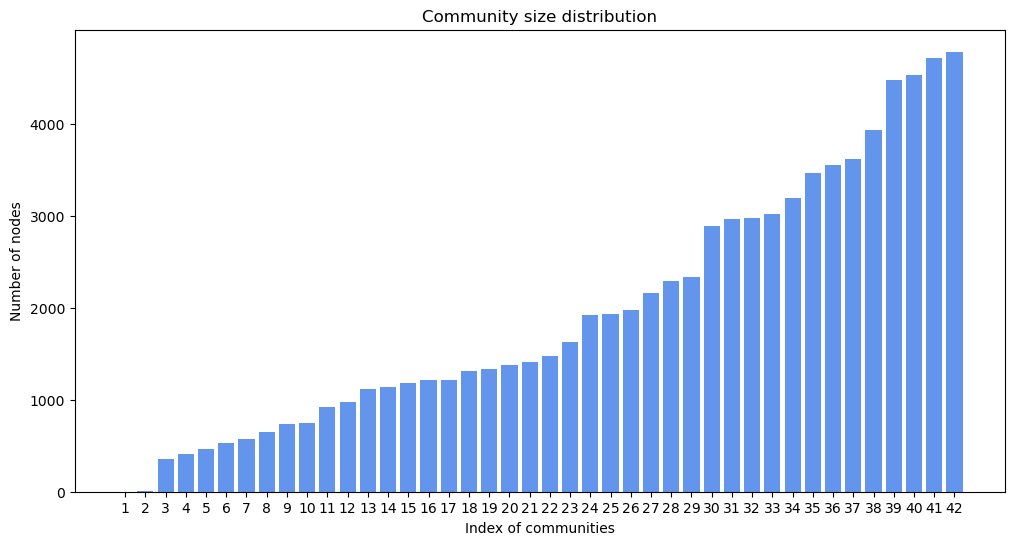

Size of each community printed:  [2, 3, 356, 407, 469, 534, 572, 654, 735, 746, 919, 979, 1122, 1144, 1181, 1216, 1221, 1309, 1335, 1384, 1408, 1475, 1625, 1927, 1931, 1978, 2163, 2290, 2339, 2893, 2965, 2976, 3022, 3192, 3471, 3555, 3618, 3936, 4482, 4541, 4716, 4789]


In [8]:
import matplotlib.pyplot as plt
sorted_size_communities = sorted([len(comm) for comm in louvain_partition])

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(
    [x for x in range(1,len(louvain_partition)+1)], 
    sorted_size_communities,
    color="cornflowerblue"
)
ax.set_title(label="Community size distribution")
ax.set_xlabel(xlabel="Index of communities")
ax.set_ylabel(ylabel="Number of nodes")
ax.set_xticks([x for x in range (1,len(louvain_partition)+1)])
ax.set_yticks([i for i in range (0, sorted_size_communities[-1], 1000)])
plt.show()

print("Size of each community printed: ", sorted_size_communities)

Testing the type partition's modularity. Unsurprisingly this is not a good partition.

In [9]:
type_partition_modularity = nx.community.modularity(G_undirected, list(type_grouping.values()))
print("Type partition modularity:", type_partition_modularity)

Type partition modularity: -0.4968922173863245


## Connecting talk pages by common editors

We create a graph where the nodes are the talk pages and two nodes are connected by an edge of weight w if exactly w users contributed to both.

In [10]:
edits_u = G_edits.to_undirected()
G_talks = G_undirected.subgraph(type_grouping["talk"])
G_users = G_undirected.subgraph(type_grouping["user"])
print(f"Connections between talk pages: {G_talks.number_of_edges()}")
print(f"Connections between user pages: {G_users.number_of_edges()}")

Connections between talk pages: 0
Connections between user pages: 0


In [11]:
talks_sub = nx.Graph()

for page in type_grouping["talk"]:
    editors = set(edits_u.neighbors(page))
    related = {}
    for user in editors:
        r_user = edits_u.neighbors(user)
        for talk in r_user:
            if talk != page:
                if talk in related:
                    related[talk] += 1
                else:
                    related[talk] = 1
    talks_sub.add_weighted_edges_from([(page, r, related[r]) for r in related])


Basic analysis on the resulting graph. Slight change in top 5 nodes by degree is probably due to users that only contributed to one article being filtered out.

In [12]:
print(f"Number of nodes: {talks_sub.number_of_nodes()}")
print(f"Number of edges: {talks_sub.number_of_edges()}")
print(f"Number of connected components: {nx.number_connected_components(talks_sub)}")
_, degree_stats = basic_stats_undirected(talks_sub, 5)
# 
print("Top 5 nodes by overall degree")
degree_stats

Number of nodes: 999
Number of edges: 242134
Number of connected components: 1
Top 5 nodes by overall degree


,Degree
Node,
Talk:United States,962
Talk:Climate change,945
Talk:Jesus,944
Talk:Human,931
Talk:Atheism,923


Least popular articles to edit.

In [13]:
degree_view = pd.DataFrame(talks_sub.degree, columns=["Node", "Degree"]).set_index("Node")
degree_view.sort_values(["Degree"], ascending=True).head(5)

,Degree
Node,
Talk:History of Oceania,6
Talk:Internal structure of Earth,36
Talk:History of North America,45
Talk:Mechanical engineering,45
Talk:Festival,46


Most connected pairs of talk pages based on number of authors who edited both. Popularity of the two pages might also play a role.

In [14]:
edge_weight_dict = nx.get_edge_attributes(talks_sub, "weight")
stat_view = pd.DataFrame({"Edge": edge_weight_dict.keys(), "Weight": edge_weight_dict.values()}).set_index("Edge")
most_raw_connected = stat_view.sort_values(["Weight"], ascending=False).head(20)
most_raw_connected

,Weight
Edge,
"(Talk:Christianity, Talk:Jesus)",221
"(Talk:Israel, Talk:Jerusalem)",206
"(Talk:Muhammad, Talk:Islam)",203
"(Talk:Jesus, Talk:United States)",178
"(Talk:Jesus, Talk:Muhammad)",176
"(Talk:China, Talk:Taiwan)",174
"(Talk:Jesus, Talk:Adolf Hitler)",168
"(Talk:United Kingdom, Talk:United States)",163
"(Talk:United States, Talk:Israel)",147


Now we normalize the weights by the number of editors for each individual article. In this way the highest relative weight is assigned to the article where the biggest percentage of the editor group contributed to both.

In [15]:
for (u, v, data) in talks_sub.edges(data=True):
    raw_weight = data["weight"]
    talks_sub[u][v]["relative_weight"] = raw_weight / (edits_u.degree[u] + edits_u.degree[v]) * 100

In [16]:
relative_edge_weight_dict = nx.get_edge_attributes(talks_sub, "relative_weight")
rel_weight_df = pd.DataFrame({"Edge": relative_edge_weight_dict.keys(), "Weight": relative_edge_weight_dict.values()}).set_index("Edge")
rel_weight_df.sort_values(["Weight"], ascending=False).head(20)

,Weight
Edge,
"(Talk:Mahayana, Talk:Theravada)",14.814815
"(Talk:Post-classical history, Talk:Early modern period)",14.583333
"(Talk:Organic chemistry, Talk:Inorganic chemistry)",11.904762
"(Talk:Real number, Talk:Natural number)",11.764706
"(Talk:Complex number, Talk:Function (mathematics))",11.347518
"(Talk:Natural number, Talk:Number)",11.111111
"(Talk:Al-Khwarizmi, Talk:Avicenna)",10.666667
"(Talk:Jupiter, Talk:Neptune)",10.628019
"(Talk:Venus, Talk:Jupiter)",10.606061


Let's see the most connected by raw user count.

In [17]:
rel_weight_df.loc[most_raw_connected.index]

,Weight
Edge,
"(Talk:Christianity, Talk:Jesus)",7.716480
"(Talk:Israel, Talk:Jerusalem)",9.163701
"(Talk:Muhammad, Talk:Islam)",8.045977
"(Talk:Jesus, Talk:United States)",4.341463
"(Talk:Jesus, Talk:Muhammad)",5.374046
"(Talk:China, Talk:Taiwan)",9.780776
"(Talk:Jesus, Talk:Adolf Hitler)",4.922356
"(Talk:United Kingdom, Talk:United States)",4.781461
"(Talk:United States, Talk:Israel)",3.836117


## Community analysis on talk pages graph
It seems that a grouping of talk pages based on common editors emerges from our analysis. We will investigate this further with community analysis.

In [18]:
louvain_partition_raw = nx.community.louvain_communities(talks_sub)
print("Weights are common user numbers:")
print( "number of communities found: ", len(louvain_partition_raw))
print("modularity of louvain partitions: ", nx.community.modularity(talks_sub, louvain_partition_raw))

for idx, c in enumerate(louvain_partition_raw):
    print(f"{idx + 1}: ", ", ".join([a[5:] for a in c]))

print("---------------------------------")


louvain_partition_rel = nx.community.louvain_communities(talks_sub, weight="relative_weight")
print("Weights are relative user numbers:")
print( "number of communities found: ", len(louvain_partition_rel))
print("modularity of louvain partitions: ", nx.community.modularity(talks_sub, louvain_partition_rel))

for idx, c in enumerate(louvain_partition_rel):
    print(f"{idx + 1}: ", ", ".join([a[5:] for a in c]))


Weights are common user numbers:
number of communities found:  5
modularity of louvain partitions:  0.10924780188786126
1:  Louis Armstrong, Vedas, Shia Islam, History of music, George Washington, Prayer, Grassland, Lake Victoria, John Locke, Piano, Moses, Pablo Picasso, Justice, Adam Smith, Plato, Stone Age, European colonization of the Americas, Dante Alighieri, Homer, Christopher Columbus, Michelangelo, Mecca, Mughal Empire, History of East Asia, Hokusai, Monarchy, Abstract art, Himalayas, Music, Industrial Revolution, Popular culture, Eastern philosophy, Aztecs, Mumbai, Cyrus the Great, Michael Faraday, Louis Pasteur, Elizabeth I, Suleiman the Magnificent, Indigenous peoples, History, Calendar, English literature, Paper, Judaism, Confucianism, Civilization, Cicero, Liberty, Holy Roman Empire, Language, Ancient history, Nile, Augustus, Fiction, Sigmund Freud, Shinto, Bible, Islam, Religion, James Cook, William Shakespeare, Civil engineering, Age of Discovery, Folk music, Fashion, Av

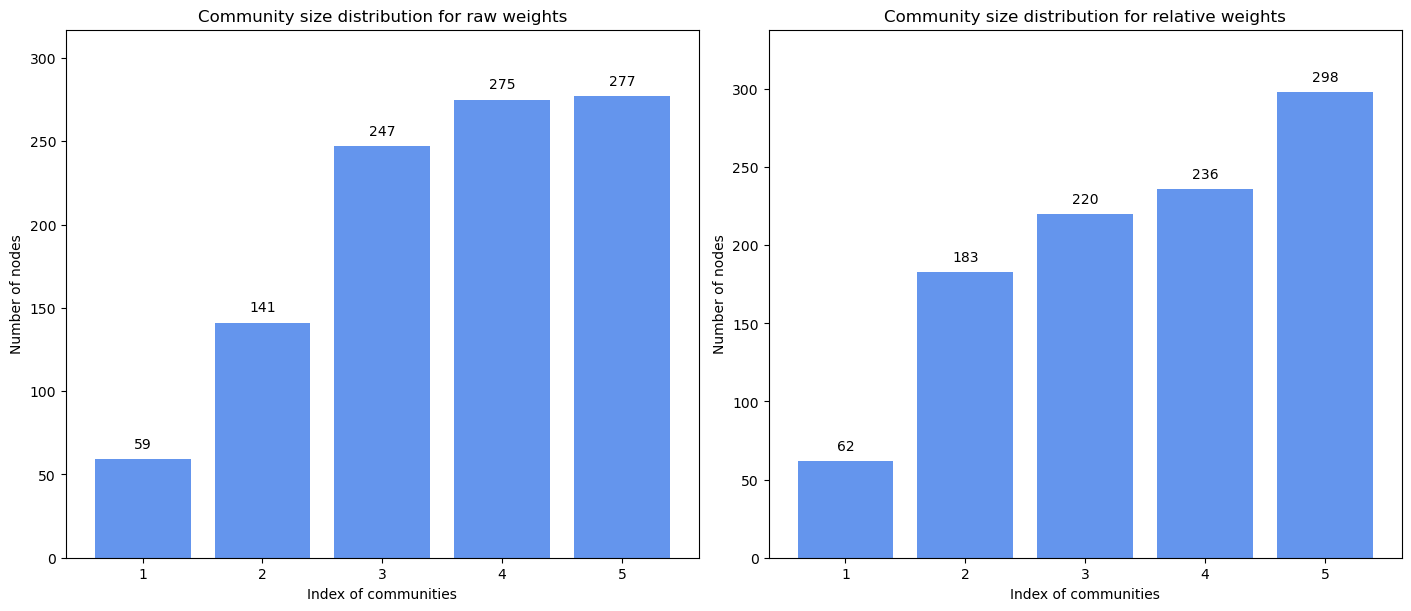

In [33]:
titles = ["Community size distribution for raw weights", "Community size distribution for relative weights"]
partitions = [louvain_partition_raw, louvain_partition_rel]
fig, ax = plt.subplots(1, 2, figsize=(14, 6), layout="constrained")
for idx, (titles, partition) in enumerate(zip(titles, partitions)):
    sorted_size_communities = sorted([len(comm) for comm in partition])
    ax[idx].bar([x for x in range(1,len(partition)+1)], sorted_size_communities, color="cornflowerblue")
    ax[idx].set_title(label=titles)
    ax[idx].set_xlabel(xlabel="Index of communities")
    ax[idx].set_ylabel(ylabel="Number of nodes")
    ax[idx].set_xticks([x for x in range (1,len(partition)+1)])
    min_c = sorted_size_communities[0]
    max_c = sorted_size_communities[-1]
    ax[idx].set_ylim((0, max_c + 40))

    rects = ax[idx].patches
    labels = [size for size in sorted_size_communities]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax[idx].text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")
    
plt.show()

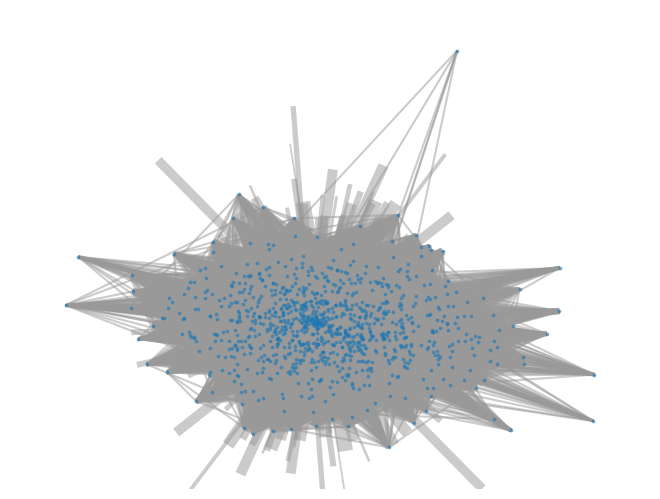

In [35]:
pos = nx.spring_layout(talks_sub)
label_pos = {node: (pos[node][0], pos[node][1] + 0.15) for node in talks_sub.nodes}
raw_edge_weights = np.array([data["weight"] for _, _, data in talks_sub.edges(data=True)])
edge_widths = raw_edge_weights / raw_edge_weights.mean() * 5
nx.draw(talks_sub, pos=pos, node_size=3, edge_color="#999999", width=edge_widths, alpha=0.5, with_labels=False)
# nx.draw_networkx_labels(talks_sub, pos, font_size=5, font_color='black')
plt.show()